In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import pandas as pd
import csv
df = pd.read_csv('/content/IMDB_Dataset.csv', delimiter=',', on_bad_lines="skip")

df.count()

review       50000
sentiment    50000
dtype: int64

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
print(df.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. The filming tec...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Initialize the CountVectorizer to create n-grams
vectorizer = CountVectorizer(ngram_range=(1, 2))  # This will create 1-grams and 2-grams

corpus = []
batch_size = 5000
num_batches = len(df) // batch_size + 1

for batch_idx in range(num_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(df))
    for i in range(start_idx, end_idx):
        review = re.sub('[^a-zA-Z]', ' ', df['review'][i])  # You read the review from the dataframe here
        review = review.lower()  # Now you can lower case it
        review = review.split()
        review = [lemmatizer.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
        review = ' '.join(review)
        corpus.append(review)
    print(f'Finished processing batch {batch_idx + 1} of {num_batches}')

# Create n-grams
X = vectorizer.fit_transform(corpus)


Finished processing batch 1 of 11
Finished processing batch 2 of 11
Finished processing batch 3 of 11
Finished processing batch 4 of 11
Finished processing batch 5 of 11
Finished processing batch 6 of 11
Finished processing batch 7 of 11
Finished processing batch 8 of 11
Finished processing batch 9 of 11
Finished processing batch 10 of 11
Finished processing batch 11 of 11


In [ ]:
# Import necessary libraries for the next steps
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
# Create the Bag of Words model
cv = CountVectorizer(max_features = 1500)
X = cv.fit_transform(corpus).toarray()
y = df.iloc[:, 1].values

# Encode labels
y = np.where(y=='positive', 1, 0)

In [ ]:
# Split the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [ ]:
# Fit Naive Bayes to the Training set
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

MultinomialNB()

In [ ]:
# Predict the Test set results
y_pred = classifier.predict(X_test)

In [ ]:
# Make the Confusion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

[[4146  815]
 [ 771 4268]]
Accuracy: 0.8414


In [ ]:
!pip install torch
!pip install transformers
!pip install accelerate[torch]
import torch
print(torch.__version__)

In [ ]:
# Import necessary libraries for fine-tuning
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
import torch

# Check if CUDA is available and set device to GPU if it is
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# Define the model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [ ]:
# Convert labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label)
        }

# Create instances of the custom dataset
train_dataset = CustomDataset(X_train, y_train_encoded, tokenizer)
val_dataset = CustomDataset(X_test, y_test_encoded, tokenizer)


In [ ]:
#ONLY RUN THIS IF YOU WANT TO CHECK THE BEST HYPERPARAMETERS FOR YOURSELF! 
#IT TAKES EXTREAMLY LONG EVEN WITH COLAB PRO (4 hours nearly)
#I used the best parameters that I got a bit further down in the file

from transformers import Trainer, TrainingArguments
from itertools import product

# Define the hyperparameters to search over
param_grid = {
    'num_train_epochs': [2, 3, 4],
    'per_device_train_batch_size': [16, 32],
    'per_device_eval_batch_size': [64, 128],
    'warmup_steps': [500, 1000],
    'weight_decay': [0.01, 0.05],
}

# Get all combinations of hyperparameters
param_combinations = list(product(*param_grid.values()))

# Initialize variables to store the best score and parameters
best_score = None
best_params = None

# Iterate over all combinations of hyperparameters
for params in param_combinations:
    # Unpack the parameters
    num_train_epochs, per_device_train_batch_size, per_device_eval_batch_size, warmup_steps, weight_decay = params

    # Define the training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        warmup_steps=warmup_steps,
        weight_decay=weight_decay,
        logging_dir='./logs',
        logging_steps=250,
    )

    # Create the Trainer and train the model
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset
    )

    # Train the model and get the training output
    train_output = trainer.train()

    # Get the evaluation score
    # You might need to modify this depending on what score you want to optimize
    eval_score = trainer.evaluate()['eval_loss']

    # If this score is better than the previous best score, update the best score and parameters
    if best_score is None or eval_score < best_score:
        best_score = eval_score
        best_params = params

# Print the best score and parameters
print('Best score:', best_score)
print('Best parameters:', best_params)


Step,Training Loss
250,0.693200
500,0.694300
750,0.692700
1000,0.692600
1250,0.689900
1500,0.689500


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.692600
500,0.692400
750,0.688400
1000,0.683100
1250,0.671500
1500,0.665500


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.695100
500,0.670400
750,0.589300
1000,0.671100
1250,0.696200
1500,0.692700


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.696100
500,0.698000
750,0.685800
1000,0.680200
1250,0.678500
1500,0.678100


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.697200
500,0.687700
750,0.620400
1000,0.641500
1250,0.623000
1500,0.641600


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.693300
500,0.618700
750,0.481600
1000,0.541900
1250,0.517700
1500,0.603400


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.670100
500,0.479300
750,0.317300
1000,0.425200
1250,0.448000
1500,0.581600


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.651300
500,0.394600
750,0.273300
1000,0.322200
1250,0.340200
1500,0.517700


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.718600
500,0.704600
750,0.701800


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.696100
500,0.700000
750,0.699300


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.693400
500,0.661300
750,0.688300


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.692400
500,0.611300
750,0.656000


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.693500
500,0.569000
750,0.603300


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.709800
500,0.455900
750,0.524400


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.721600
500,0.368500
750,0.421000


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.667100
500,0.303400
750,0.347100


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.715200
500,0.705400
750,0.602500
1000,0.428000
1250,0.507400
1500,0.622400
1750,0.696600
2000,0.699800
2250,0.697900


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.678800
500,0.534100
750,0.384800
1000,0.294000
1250,0.342100
1500,0.501600
1750,0.679500
2000,0.697000
2250,0.695600


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.638700
500,0.386700
750,0.238800
1000,0.224800
1250,0.283700
1500,0.442400
1750,0.658200
2000,0.693700
2250,0.694900


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.622400
500,0.312100
750,0.225200
1000,0.196500
1250,0.310200
1500,0.361900
1750,0.611600
2000,0.685500
2250,0.691500


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.608200
500,0.291500
750,0.186900
1000,0.264200
1250,0.248100
1500,0.293500
1750,0.556300
2000,0.664900
2250,0.684700


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.573100
500,0.276100
750,0.159000
1000,0.206000
1250,0.200200
1500,0.246800
1750,0.507200
2000,0.640700
2250,0.679600


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.553400
500,0.273500
750,0.176300
1000,0.166800
1250,0.190800
1500,0.245200
1750,0.487100
2000,0.635800
2250,0.668600


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.567000
500,0.205300
750,0.167800
1000,0.155500
1250,0.194500
1500,0.251800
1750,0.449600
2000,0.596600
2250,0.660100


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.705500
500,0.650300
750,0.631400
1000,0.685500


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.687500
500,0.534600
750,0.503100
1000,0.647800


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.668400
500,0.402600
750,0.363800
1000,0.608300


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.670400
500,0.340400
750,0.297000
1000,0.555700


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.657100
500,0.311800
750,0.291400
1000,0.539000


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.623800
500,0.251200
750,0.252500
1000,0.484500


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.597600
500,0.253400
750,0.264500
1000,0.429000


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.602500
500,0.219000
750,0.309600
1000,0.456700


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.713900
500,0.703600
750,0.496200
1000,0.416700
1250,0.415900
1500,0.483400
1750,0.608800
2000,0.669100
2250,0.687200
2500,0.705900


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.654800
500,0.427200
750,0.224400
1000,0.254200
1250,0.291400
1500,0.400200
1750,0.533900
2000,0.642600
2250,0.671600
2500,0.702300


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.630400
500,0.288900
750,0.126400
1000,0.195100
1250,0.225000
1500,0.295000
1750,0.467200
2000,0.611900
2250,0.655900
2500,0.693500


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.634800
500,0.241600
750,0.113100
1000,0.202000
1250,0.222000
1500,0.265000
1750,0.408500
2000,0.571900
2250,0.629800
2500,0.676600


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.608400
500,0.217500
750,0.115100
1000,0.195700
1250,0.149500
1500,0.204000
1750,0.366200
2000,0.524900
2250,0.595500
2500,0.650300


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.579400
500,0.227100
750,0.141200
1000,0.202100
1250,0.165400
1500,0.201200
1750,0.330700
2000,0.480800
2250,0.565900
2500,0.634400


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.570700
500,0.189100
750,0.150500
1000,0.154000
1250,0.145900
1500,0.195000
1750,0.300700
2000,0.507900
2250,0.557700
2500,0.618800


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.568000
500,0.127400
750,0.093400
1000,0.148200
1250,0.156000
1500,0.205700
1750,0.293200
2000,0.432800
2250,0.526200
2500,0.594800


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.695600
500,0.619700
750,0.541600
1000,0.629100
1250,0.682800
1500,0.700800


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.670300
500,0.431600
750,0.350300
1000,0.525400
1250,0.641400
1500,0.697700


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.631100
500,0.279400
750,0.239600
1000,0.434700
1250,0.603100
1500,0.693700


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.631400
500,0.209600
750,0.189500
1000,0.369900
1250,0.542400
1500,0.681800


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.616400
500,0.198000
750,0.207100
1000,0.365000
1250,0.499200
1500,0.648100


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.586200
500,0.196800
750,0.208200
1000,0.336300
1250,0.454300
1500,0.624600


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.568600
500,0.201400
750,0.157900
1000,0.307300
1250,0.431700
1500,0.623700


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
250,0.563800
500,0.128500
750,0.134900
1000,0.299100
1250,0.395000
1500,0.598200


Best score: 0.6927798986434937
Best parameters: (3, 16, 128, 500, 0.01)


In [ ]:
#Best score: 0.6927798986434937
#Best parameters: (3, 16, 128, 500, 0.01)

from transformers import Trainer, TrainingArguments

# Define the training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=128,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=250,
)

# Create the Trainer and train the model
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset             # evaluation dataset
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 26>:26                                                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1645 in train                    │
│                                                                                                  │
│   1642 │   │   inner_training_loop = find_executable_batch_size(                                 │
│   1643 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batch_size  │
│   1644 │   │   )                                                                                 │
│ ❱ 1645 │   │   return inner_training_loop(                                                       │
│   1646 │   │   │   args=args,                                                                    │
│   1647 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                                │
│   1648 │   │   │   trial=trial,                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:1943 in _inner_training_loop     │
│                                                                                                  │
│   1940 │   │   │   │   if (                                                                      │
│   1941 │   │   │   │   │   args.logging_nan_inf_filter                                           │
│   1942 │   │   │   │   │   and not is_torch_tpu_available()                                      │
│ ❱ 1943 │   │   │   │   │   and (torch.isnan(tr_loss_step) or torch.isinf(tr_loss_step))          │
│   1944 │   │   │   │   ):                                                                        │
│   1945 │   │   │   │   │   # if loss is nan or inf simply add the average of previous logged lo  │
│   1946 │   │   │   │   │   tr_loss += tr_loss / (1 + self.state.global_step - self._globalstep_  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [ ]:
# Evaluate the model on the validation dataset
eval_result = trainer.evaluate()

# Print the evaluation result
print(eval_result)

# Save model
trainer.save_model()


{'eval_loss': 0.6932567358016968, 'eval_runtime': 75.5615, 'eval_samples_per_second': 132.343, 'eval_steps_per_second': 1.046, 'epoch': 3.0}


In [ ]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, predictions)}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# Now when you call evaluate, it will also compute accuracy
eval_result = trainer.evaluate()

# Print the evaluation result
print(eval_result)


{'eval_loss': 0.6932567358016968, 'eval_accuracy': 0.4961, 'eval_runtime': 77.4696, 'eval_samples_per_second': 129.083, 'eval_steps_per_second': 1.02}


In [ ]:
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import joblib

# Create the logistic regression model
lr = LogisticRegression(penalty='l2', max_iter=1000, C=1, random_state=42)

# Train the model on the training set
lr.fit(X_train, y_train)

# Predict using the trained model
y_pred = lr.predict(X_test)

# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy)

# Save the logistic regression model to a file
lr_model_path = os.path.join('results', 'logistic_regression_model.pkl')
joblib.dump(lr, lr_model_path)


Confusion Matrix:
 [[4290  671]
 [ 622 4417]]
Accuracy: 0.8707


In [ ]:
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import joblib

# Create the "results" folder if it doesn't exist
if not os.path.exists('results'):
    os.makedirs('results')

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

print("Random Forest Classifier:")
print("Confusion Matrix:\n", cm_rf)
print("Accuracy:", accuracy_rf)

# Save the Random Forest model to a file
rf_model_path = os.path.join('results', 'random_forest_model.pkl')
joblib.dump(rf, rf_model_path)

Random Forest Classifier:
Confusion Matrix:
 [[4189  772]
 [ 828 4211]]
Accuracy: 0.84


['results/random_forest_model.pkl']

In [ ]:
# Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
cm_dt = confusion_matrix(y_test, y_pred_dt)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

print("\nDecision Tree Classifier:")
print("Confusion Matrix:\n", cm_dt)
print("Accuracy:", accuracy_dt)

# Save the Decision Tree model to a file
dt_model_path = os.path.join('results', 'decision_tree_model.pkl')
joblib.dump(dt, dt_model_path)


Decision Tree Classifier:
Confusion Matrix:
 [[3509 1452]
 [1438 3601]]
Accuracy: 0.711


['results/decision_tree_model.pkl']

In [ ]:
#ONLY RUN THIS IF YOU WANT TO CHECK THE BEST HYPERPARAMETERS FOR YOURSELF! 
#IT TAKES EXTREAMLY LONG EVEN WITH COLAB PRO (2.5 hours nearly)
#I used the best parameters that I got a bit further down in the file

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Create the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the model with best hyperparameters on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Accuracy: 0.8444


In [ ]:
#Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
#Accuracy: 0.8444

import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import joblib

# Create the Random Forest classifier with the best hyperparameters
rf = RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300, random_state=42)

# Train the model on the training set
rf.fit(X_train, y_train)

# Predict using the trained model
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Save the trained model to a file
model_path = os.path.join('results', 'trained_random_forest_model.pkl')
joblib.dump(rf, model_path)
# Save the vectorizer
joblib.dump(vectorizer, "results/vectorizer.pkl")


Accuracy: 0.9707


['results/vectorizer.pkl']

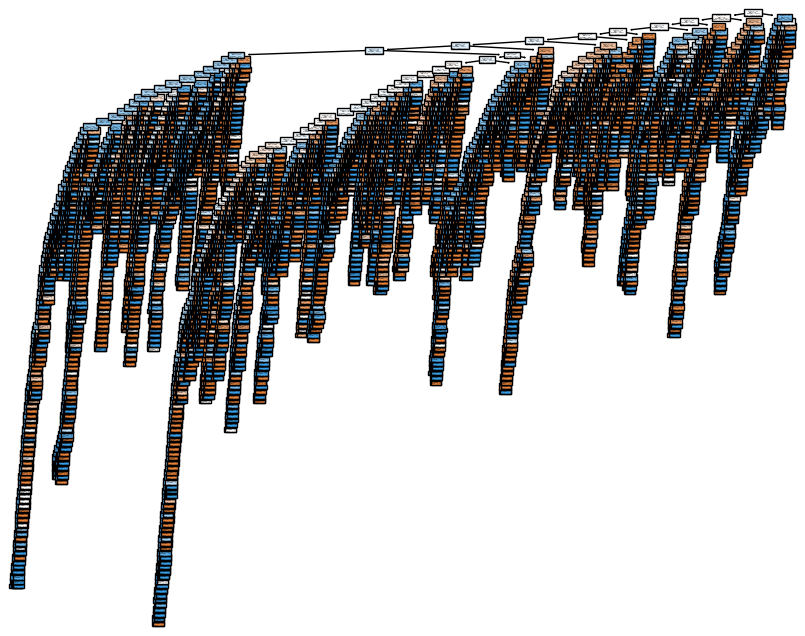

In [ ]:
from sklearn import tree
import matplotlib.pyplot as plt

# Visualize a specific tree within the Random Forest
plt.figure(figsize=(10, 8))
tree.plot_tree(rf.estimators_[0], feature_names=None, filled=True)
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2106)

# Train the model on the training set
rf.fit(X_train, y_train)

# Make predictions on the validation set
y_pred_val = rf.predict(X_val)

# Calculate accuracy on the validation set
accuracy_val = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy:", accuracy_val)


Validation Accuracy: 0.8451
